## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)
MODEL_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "model")
try_mkdir(MODEL_PATH)

GF_DATA_PATH = os.path.join(DATA_PATH, "gf3d")
try_mkdir(GF_DATA_PATH)
GF_MODEL_PATH = os.path.join(MODEL_PATH, "gf3d")
try_mkdir(GF_MODEL_PATH)

In [3]:
VISUALIZE = False
ROBOT_TYPE = RobotType.panda

if ROBOT_TYPE == RobotType.indy7:
    ROBOT_NAME = "indy0"
    TOOL_LINK = "indy0_tcp"
    TOOL_XYZ = (0,0,0.14)
    GRIP_DEPTH = 0.05
    HOME_POSE = (0,0,0,0,0,0)
elif ROBOT_TYPE == RobotType.panda:
    ROBOT_NAME = "panda0"
    TOOL_LINK = "panda0_hand"
    TOOL_XYZ = (0,0,0.112)
    GRIP_DEPTH = 0.03
    HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)
else:
    raise(NotImplementedError("Unknown robot type"))


TOOL_RPY = (-np.pi/2,0,0)
CLEARANCE = 1e-3
TIMEOUT_REACH = 3
TIMEOUT_RETRIEVE = 5
TIMEOUT_PLACE = 0.1

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                None)]
              , connection_list=[False])
ROBOT_NAME = crob.robot_names[0]

connection command:
panda0: False


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# # deprecated: s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


In [7]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [8]:
from pkg.geometry.geometry import *

In [9]:
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## init planning scene

In [10]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [11]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [12]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool, point=None)

## planner

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
mplan = MoveitPlanner(pscene)

checkers=[]
gcheck = GraspChecker(pscene)
checkers.append(gcheck)
rcheck = ReachChecker(pscene)
checkers.append(rcheck)
# lcheck = LatticedChecker(pscene, gcheck)
# checkers.append(lcheck)
mplan.motion_filters = [gcheck]

## ui

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Object Classes

In [15]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask
from pkg.planning.filtering.pair_svm import get_pairwise_feature, get_step_dirYZ

PLANE_THICKNESS = 0.1
CLEARANCE = 1e-3

##
# @class ObstacleBase
# @brief base class for obstacle generators
class ObstacleBase:
    RTH_MIN = None ## R: center ~ nearest point
    RTH_MAX = None
    RPY_MIN = None
    RPY_MAX = None
    DIM_MIN = None
    DIM_MAX = None
    GTYPE = None
    COLOR = (0.7,0.7,0.7,1)
    
    def __init__(self, gscene, name, sampler=np.random.uniform, DIM=None, RTH=None, RPY=None):
        self.name = name
        self.DIM = sampler(self.DIM_MIN, self.DIM_MAX) if DIM is None else DIM
        self.RTH = sampler(self.RTH_MIN, self.RTH_MAX) if RTH is None else RTH
        self.RPY = sampler(self.RPY_MIN, self.RPY_MAX) if RPY is None else RPY
        self.RPY[2] += self.RTH[1]
        self.XYZ = np.array(cyl2cart(*self.RTH))
        verts_rotated = np.matmul(Rot_rpy(self.RPY), (DEFAULT_VERT_DICT[self.GTYPE]*self.DIM).transpose())
        xy_normed = self.XYZ[:2]/(np.linalg.norm(self.XYZ[:2])+1e-6)
        verts_r_compo = np.dot(xy_normed, verts_rotated[:2,:])
        self.XYZ[:2] -= xy_normed[:2]*np.min(verts_r_compo)
        self.RTH[0] -= np.min(verts_r_compo)
        self.geometry = gscene.create_safe(gtype=self.GTYPE, name=self.name, link_name="base_link", 
                                  dims=self.DIM, center=tuple(self.XYZ), rpy=self.RPY,
                                  color=self.COLOR, display=True, collision=True, fixed=True)
        self.subgeo_list = []
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_me, raddii_me = self.geometry.get_vertice_radius()
        verts_me_global = np.add(np.matmul(verts_me, self.geometry.orientation_mat.transpose()), 
                                 self.geometry.center)
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_me_global))-radii-raddii_me < 1e-4
        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.3, +np.pi/2, 0.5)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.6, 0.6, PLANE_THICKNESS)
    DIM_MAX = (0.6, 0.6, PLANE_THICKNESS)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, *args, **kwargs):
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.2, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.055, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.RPY = (0,0,0)
        self.geometry.set_offset_tf(center = self.XYZ, orientation_mat=Rot_rpy(self.RPY))
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        
def clear_class(gscene, key, Nmax):
    for iw in range(Nmax):
        gname = "{}_{}".format(key, iw)
        if gname in gscene.NAME_DICT:
            gscene.remove(gscene.NAME_DICT[gname])

            
def disperse_objects(gscene, object_class, key, Nobj, workplane_on):
    clear_class(gscene, key, Nobj)
        
    obs_list = []
    for iw in range(Nobj):
        while len(obs_list) != iw+1:
            obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
            remove_this = False
            for obs_pre in obs_list:
                if obs_pre.is_overlapped_with(obs.geometry):
                    remove_this = True
                    break
            if remove_this:
                gscene.remove(obs.geometry)
            else:
                obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,-np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,-np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,+np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2-CLEARANCE], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, (0,0,0), (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_subject(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles

ROBOT_DATA_ROOT = os.path.join(GF_DATA_PATH, ROBOT_TYPE.name)
try_mkdir(ROBOT_DATA_ROOT)

# Dev GF3DSVM

In [16]:
from pkg.planning.filtering.pair_svm import PairSVM
pchecker = MoveitPlanner(pscene)
pchecker.motion_filters = [PairSVM(pscene)]
checkers = [pchecker]

In [17]:
print("Testing filters:")
for checker in checkers:
    for ft in checker.motion_filters:
        print("\t {}".format(ft.__class__.__name__))
    
print("Planner filters:")
for ft in mplan.motion_filters:
    print("\t {}".format(ft.__class__.__name__))

Testing filters:
	 PairSVM
Planner filters:
	 GraspChecker


# Test script

In [18]:
def test_script(N_obj, N_max_sample, N_place=2):
    N_print = 10
    SHOW_PERIOD = 0.01

    i_s = 0
    i_print = 0
    filter_results_dict = defaultdict(list)
    filter_time_dict = defaultdict(list)
    filter_results_dict_place = defaultdict(list)

    feature_time_list = []
    reach_list = []
    retrieve_list = []
    place_list = []
    gtimer = GlobalTimer.instance()
    gtimer.reset(stack=True)
    gtimer.tic("full_loop")
    while i_s < N_max_sample:
        ## set workplane
        wp = WorkPlane(gscene, "wp")
        wp_pscene = pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane, point=None)

        ## add object
        obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
        obj_names = [obj_tmp.name for obj_tmp in obj_list]

        obj = obj_list[0]
        obj_pscene, handles = add_object(pscene, obj)
        mplan.update_gscene()
        for rotate_obj in [False, True]:
            if rotate_obj:
                obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
            else:
                obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
            obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                        Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))

            for obj_tmp in obj_list[1:]:
                Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
                i_rot = random.choice([0,1])
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
                if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                    obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                    obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                             Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
                while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                    obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

            initial_state = pscene.initialize_state(HOME_POSE)
            pscene.set_object_state(initial_state)
            from_state = initial_state.copy(pscene)
            to_node = ("grip0",)
            place_node = ("wp",)
            place_point = obj_pscene.action_points_dict['placement']
            for bp in sorted(obj_pscene.action_points_dict.keys()):
                pscene.set_object_state(initial_state)
                gscene.update_markers_all()
                handle = obj_pscene.action_points_dict[bp]
                if not gripper.check_type(handle):
                    continue
                to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
                redundancy_dict['obj_0']['grip0']['w'] = 0
                redundancy_dict['obj_0'][bp]['w'] = 0
                redundancy_dict['obj_0'][bp]['x'] = 0
                redundancy_dict['obj_0'][bp]['y'] = 0
                redundancy_dict_pick = redundancy_dict

                for checker in checkers:
                    fname = []
                    for ft in checker.motion_filters:
                        fname.append(ft.__class__.__name__)
                    fname = "-".join(fname)
                    gtimer.tic(fname)
                    res = checker.plan_transition(
                        from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                    etime = gtimer.toc(fname)
                    filter_time_dict[fname].append(etime)
                    filter_results_dict[fname].append(res)

                success_reach, success_retrieve, success_place = False, False, False
                with gtimer.block("reach"):
                    Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                        from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)

                Traj_retrieve = []
                if success_reach:
                    if VISUALIZE:
                        gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                    for bd in binding_list:
                        pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                    binding_state, state_param = pscene.get_object_state()
                    new_state = State(binding_state, state_param, list(LastQ), pscene)
                    end_state = new_state.copy(pscene)
                    end_state.Q = np.array(HOME_POSE)
                    with gtimer.block("retrieve"):
                        Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)

                if success_retrieve:
                    if VISUALIZE:
                        gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)

                    for bd in binding_list:
                        pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                    binding_state, state_param = pscene.get_object_state()
                    new_state = State(binding_state, state_param, list(LastQ), pscene)

                    for _ in range(N_place):
                        Traj_place = []
                        pscene.set_object_state(new_state)
                        to_state, redundancy_dict = pscene.sample_leaf_state(
                            new_state, {'obj_0': [('placement', 'wp', 'wp')]}, place_node)

    #                     print("=" * 37 + " PLACE " + "=" * 37)

                        filter_result_tmp = []
                        for checker in checkers:
                            fname = []
                            for ft in checker.motion_filters:
                                fname.append(ft.__class__.__name__)
                            fname = "-".join(fname)
                            res = checker.plan_transition(
                                from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                            filter_results_dict_place[fname].append(res)
                            filter_result_tmp.append(res)

                        with gtimer.block("place"):
                            Traj_place, LastQ, error, success_place, binding_list = mplan.plan_transition(
                                from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_PLACE)
                        place_list.append(success_place)

                        if success_place:
                            if VISUALIZE:
                                gscene.show_motion(Traj_place, period=SHOW_PERIOD)

                            for bd in binding_list:
                                pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                            binding_state, state_param = pscene.get_object_state()
                            tmp_state = State(binding_state, state_param, list(LastQ), pscene)
                            tmp_state.Q = crob.home_pose
                            for ftres, checker in zip(filter_result_tmp, checkers):
                                res = checker.plan_transition(
                                    from_state=tmp_state, to_state=new_state, redundancy_dict=redundancy_dict_pick, test_filters_only=True)
                                if not res == ftres:
                                    print("place-pick prediction mismatch")
    #                         for obj_obs in obj_list:
    #                             if obj_obs.geometry == obj_pscene.geometry:
    #                                 continue
    #                             Tobj = obj_pscene.geometry.get_tf(LastQ, from_link="panda0_link0")
    #                             featurevec = get_pairwise_feature(
    #                                 Tobj, 
    #                                 obj_pscene.geometry.dims,
    #                                 obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
    #                             print("ORIGINAL FEA {}: {}".format(obj_obs.geometry.name, np.round(featurevec, 2)))
    #                             print("Tobj: \n {}".format(Tobj))
    #                             print("Toff: \n {}".format(obj_pscene.geometry.Toff))

    #                     print("=" * 80)

                pscene.set_object_state(from_state)
                reach_list.append(success_reach)
                retrieve_list.append(success_retrieve)

            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
        i_s += 1
        gscene.update_markers_all()
        if i_s > 0 :
            if i_s > i_print*N_print:
                i_print +=  1
                print_end = "\n"
            else:
                print_end = "\r"
            time_elapsed = gtimer.toc("full_loop")/1000
            print("{} / {} in {} / {} s -- reach, retrieve, place = ({} %, {} %, {} %)                     ".format(
                i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
                round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
                round(np.mean(place_list)*100, 1)))#, end=print_end)

    time_elapsed = gtimer.toc("full_loop")/1000
    print("")
    print("")
    print("============= Finished {} in {} s -- reach, retrieve, place = ({} %, {} %, {} %) =================".format(
        i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
        round(np.mean(place_list)*100, 1)))

    import matplotlib.pyplot as plt
    reach_time_log = gtimer.timelist_dict["reach"]
    retrieve_time_log = gtimer.timelist_dict["retrieve"]
    place_time_log = gtimer.timelist_dict["place"]
    plt.plot(sorted(reach_time_log), '.')
    plt.plot(sorted(retrieve_time_log), '.')
    plt.plot(sorted(place_time_log), '.')

    result_list = []
    for checker in checkers:
        fname = []
        for ft in checker.motion_filters:
            fname.append(ft.__class__.__name__)
        fname = "-".join(fname)

        print("=" * 35 + " RETRIEVE " + "=" * 35)
        filter_results_ret = filter_results_dict[fname]
        label_array_ret = np.array(retrieve_list)
        print_confusion_mat(label_array_ret, filter_results_ret)
        print("=" * 80)

        print("=" * 36 + " PLACE " + "=" * 37)
        filter_results_plc = filter_results_dict_place[fname]
        label_array_plc = place_list
        print_confusion_mat(label_array_plc, filter_results_plc)
        print("=" * 80)
        
        result_list.append(
            (fname, (label_array_ret, filter_results_ret), (label_array_plc, filter_results_plc)))
    
    return result_list

In [19]:
results_all = []

## test 2 object

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



1 / 100 in 6.2 / 620.29 s -- reach, retrieve, place = (0.0 %, 0.0 %, nan %)                     
2 / 100 in 18.94 / 947.11 s -- reach, retrieve, place = (16.7 %, 16.7 %, 25.0 %)                     
3 / 100 in 29.27 / 975.52 s -- reach, retrieve, place = (11.1 %, 11.1 %, 25.0 %)                     
4 / 100 in 39.18 / 979.46 s -- reach, retrieve, place = (16.7 %, 16.7 %, 18.8 %)                     
5 / 100 in 53.37 / 1067.47 s -- reach, retrieve, place = (26.7 %, 26.7 %, 31.3 %)                     
6 / 100 in 67.09 / 1118.16 s -- reach, retrieve, place = (31.9 %, 31.9 %, 41.3 %)                     
7 / 100 in 76.74 / 1096.24 s -- reach, retrieve, place = (35.7 %, 35.7 %, 43.3 %)                     
8 / 100 in 91.18 / 1139.8 s -- reach, retrieve, place = (33.3 %, 33.3 %, 42.2 %)                     
9 / 100 in 96.45 / 1071.68 s -- reach, retrieve, place = (33.3 %, 33.3 %, 43.1 %)                     
10 / 100 in 109.61 / 1096.12 s -- reach, retrieve, place = (31.7 %, 31.7 %, 44.7 %)

80 / 100 in 900.71 / 1125.89 s -- reach, retrieve, place = (34.0 %, 34.0 %, 41.3 %)                     
81 / 100 in 916.28 / 1131.2 s -- reach, retrieve, place = (34.4 %, 34.4 %, 41.0 %)                     
82 / 100 in 928.61 / 1132.46 s -- reach, retrieve, place = (34.5 %, 34.5 %, 40.9 %)                     
83 / 100 in 932.75 / 1123.8 s -- reach, retrieve, place = (34.0 %, 34.0 %, 40.9 %)                     
84 / 100 in 942.81 / 1122.4 s -- reach, retrieve, place = (34.6 %, 34.6 %, 40.8 %)                     
85 / 100 in 955.5 / 1124.12 s -- reach, retrieve, place = (34.7 %, 34.7 %, 41.1 %)                     
86 / 100 in 968.14 / 1125.74 s -- reach, retrieve, place = (35.1 %, 35.1 %, 41.0 %)                     
87 / 100 in 982.49 / 1129.3 s -- reach, retrieve, place = (34.9 %, 34.9 %, 40.8 %)                     
88 / 100 in 986.64 / 1121.18 s -- reach, retrieve, place = (34.5 %, 34.5 %, 40.8 %)                     
89 / 100 in 994.48 / 1117.39 s -- reach, retrieve, place = (

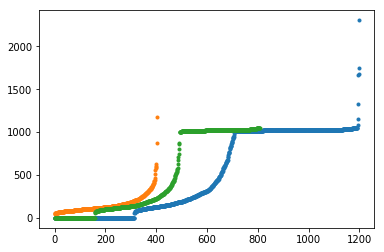

In [20]:
N_obj = 2
N_max_sample = 100
N_place = 2
result_list = test_script(N_obj=N_obj, N_max_sample=N_max_sample, N_place=N_place)
results_all.append((N_obj, result_list))

## test 3 object

1 / 100 in 8.43 / 843.4 s -- reach,retrieve = (16.7 %, 16.7 %, 0.0 %)                     
2 / 100 in 19.02 / 951.21 s -- reach,retrieve = (16.7 %, 16.7 %, 0.0 %)                     
3 / 100 in 29.31 / 977.04 s -- reach,retrieve = (11.1 %, 11.1 %, 0.0 %)                     
4 / 100 in 38.86 / 971.44 s -- reach,retrieve = (22.9 %, 22.9 %, 31.8 %)                     
5 / 100 in 44.03 / 880.53 s -- reach,retrieve = (26.7 %, 26.7 %, 37.5 %)                     
6 / 100 in 55.28 / 921.38 s -- reach,retrieve = (36.1 %, 36.1 %, 30.8 %)                     
7 / 100 in 55.32 / 790.24 s -- reach,retrieve = (31.0 %, 31.0 %, 30.8 %)                     
8 / 100 in 61.49 / 768.65 s -- reach,retrieve = (27.1 %, 27.1 %, 30.8 %)                     
9 / 100 in 68.73 / 763.62 s -- reach,retrieve = (24.1 %, 24.1 %, 30.8 %)                     
10 / 100 in 76.95 / 769.51 s -- reach,retrieve = (21.7 %, 21.7 %, 30.8 %)                     
11 / 100 in 77.0 / 700.02 s -- reach,retrieve = (19.7 %, 19.7 %,

88 / 100 in 601.08 / 683.04 s -- reach,retrieve = (23.2 %, 23.2 %, 36.9 %)                     
89 / 100 in 608.62 / 683.85 s -- reach,retrieve = (23.1 %, 23.1 %, 36.8 %)                     
90 / 100 in 615.42 / 683.8 s -- reach,retrieve = (23.2 %, 23.2 %, 36.7 %)                     
91 / 100 in 624.14 / 685.87 s -- reach,retrieve = (23.7 %, 23.7 %, 36.7 %)                     
92 / 100 in 624.17 / 678.45 s -- reach,retrieve = (23.5 %, 23.5 %, 36.7 %)                     
93 / 100 in 630.67 / 678.14 s -- reach,retrieve = (23.7 %, 23.7 %, 36.8 %)                     
94 / 100 in 630.7 / 670.96 s -- reach,retrieve = (23.5 %, 23.5 %, 36.8 %)                     
95 / 100 in 639.57 / 673.23 s -- reach,retrieve = (24.0 %, 24.0 %, 36.5 %)                     
96 / 100 in 648.43 / 675.45 s -- reach,retrieve = (24.1 %, 24.1 %, 36.7 %)                     
97 / 100 in 660.02 / 680.43 s -- reach,retrieve = (24.4 %, 24.4 %, 37.0 %)                     
98 / 100 in 669.39 / 683.05 s -- reach,ret

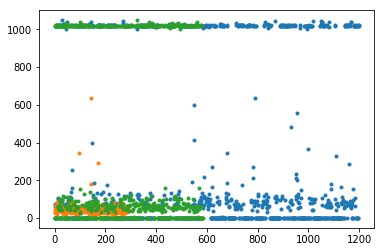

In [21]:
N_obj = 3
N_max_sample = 100
N_place = 2
result_list = test_script(N_obj=N_obj, N_max_sample=N_max_sample, N_place=N_place)
results_all.append((N_obj, result_list))

## test 4 object

1 / 100 in 0.04 / 3.87 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
2 / 100 in 8.98 / 449.06 s -- reach,retrieve = (16.7 %, 16.7 %, 25.0 %)                     
3 / 100 in 17.56 / 585.34 s -- reach,retrieve = (30.6 %, 30.6 %, 45.5 %)                     
4 / 100 in 24.0 / 600.12 s -- reach,retrieve = (39.6 %, 39.6 %, 42.1 %)                     
5 / 100 in 30.58 / 611.69 s -- reach,retrieve = (35.0 %, 35.0 %, 42.9 %)                     
6 / 100 in 36.75 / 612.53 s -- reach,retrieve = (37.5 %, 37.5 %, 40.7 %)                     
7 / 100 in 47.27 / 675.29 s -- reach,retrieve = (34.5 %, 34.5 %, 39.7 %)                     
8 / 100 in 55.47 / 693.43 s -- reach,retrieve = (30.2 %, 30.2 %, 39.7 %)                     
9 / 100 in 65.2 / 724.4 s -- reach,retrieve = (29.6 %, 29.6 %, 35.9 %)                     
10 / 100 in 73.75 / 737.52 s -- reach,retrieve = (28.3 %, 28.3 %, 36.8 %)                     
11 / 100 in 73.81 / 671.04 s -- reach,retrieve = (25.8 %, 25.8 %, 36.

87 / 100 in 585.22 / 672.67 s -- reach,retrieve = (25.2 %, 25.2 %, 30.6 %)                     
88 / 100 in 585.27 / 665.08 s -- reach,retrieve = (24.9 %, 24.9 %, 30.6 %)                     
89 / 100 in 597.68 / 671.55 s -- reach,retrieve = (25.0 %, 25.0 %, 30.1 %)                     
90 / 100 in 603.44 / 670.49 s -- reach,retrieve = (25.1 %, 25.1 %, 30.3 %)                     
91 / 100 in 613.04 / 673.67 s -- reach,retrieve = (25.0 %, 25.0 %, 30.0 %)                     
92 / 100 in 622.19 / 676.29 s -- reach,retrieve = (25.1 %, 25.1 %, 29.8 %)                     
93 / 100 in 626.32 / 673.47 s -- reach,retrieve = (24.8 %, 24.8 %, 29.8 %)                     
94 / 100 in 633.99 / 674.45 s -- reach,retrieve = (25.3 %, 25.3 %, 30.4 %)                     
95 / 100 in 639.26 / 672.9 s -- reach,retrieve = (25.0 %, 25.0 %, 30.4 %)                     
96 / 100 in 640.31 / 666.99 s -- reach,retrieve = (25.1 %, 25.1 %, 31.1 %)                     
97 / 100 in 648.51 / 668.57 s -- reach,re

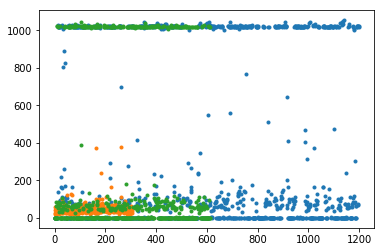

In [22]:
N_obj = 4
N_max_sample = 100
N_place = 2
result_list = test_script(N_obj=N_obj, N_max_sample=N_max_sample, N_place=N_place)
results_all.append((N_obj, result_list))

## test 5 object

1 / 100 in 7.46 / 746.44 s -- reach,retrieve = (16.7 %, 16.7 %, 25.0 %)                     
2 / 100 in 7.52 / 375.89 s -- reach,retrieve = (8.3 %, 8.3 %, 25.0 %)                     
3 / 100 in 7.55 / 251.82 s -- reach,retrieve = (5.6 %, 5.6 %, 25.0 %)                     
4 / 100 in 13.36 / 334.1 s -- reach,retrieve = (20.8 %, 20.8 %, 30.0 %)                     
5 / 100 in 23.64 / 472.81 s -- reach,retrieve = (16.7 %, 16.7 %, 30.0 %)                     
6 / 100 in 27.63 / 460.51 s -- reach,retrieve = (22.2 %, 22.2 %, 25.0 %)                     
7 / 100 in 33.79 / 482.74 s -- reach,retrieve = (19.0 %, 19.0 %, 25.0 %)                     
8 / 100 in 33.85 / 423.11 s -- reach,retrieve = (16.7 %, 16.7 %, 25.0 %)                     
9 / 100 in 42.09 / 467.71 s -- reach,retrieve = (14.8 %, 14.8 %, 25.0 %)                     
10 / 100 in 47.31 / 473.05 s -- reach,retrieve = (20.0 %, 20.0 %, 27.1 %)                     
11 / 100 in 53.48 / 486.17 s -- reach,retrieve = (21.2 %, 21.2 %, 3

87 / 100 in 507.83 / 583.72 s -- reach,retrieve = (26.2 %, 26.2 %, 25.9 %)                     
88 / 100 in 512.25 / 582.1 s -- reach,retrieve = (26.5 %, 26.5 %, 26.3 %)                     
89 / 100 in 523.14 / 587.8 s -- reach,retrieve = (26.9 %, 26.9 %, 26.0 %)                     
90 / 100 in 531.72 / 590.79 s -- reach,retrieve = (26.8 %, 26.8 %, 25.8 %)                     
91 / 100 in 539.53 / 592.89 s -- reach,retrieve = (26.5 %, 26.5 %, 25.8 %)                     
92 / 100 in 548.82 / 596.54 s -- reach,retrieve = (26.2 %, 26.2 %, 25.8 %)                     
93 / 100 in 553.4 / 595.05 s -- reach,retrieve = (26.0 %, 26.0 %, 25.9 %)                     
94 / 100 in 559.67 / 595.4 s -- reach,retrieve = (26.3 %, 26.3 %, 25.6 %)                     
95 / 100 in 561.65 / 591.21 s -- reach,retrieve = (26.6 %, 26.6 %, 25.6 %)                     
96 / 100 in 565.78 / 589.36 s -- reach,retrieve = (26.3 %, 26.3 %, 25.6 %)                     
97 / 100 in 576.72 / 594.56 s -- reach,retri

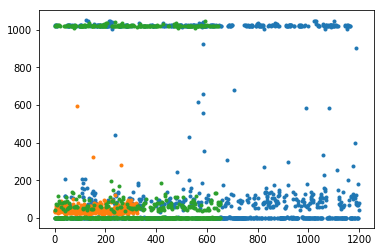

In [23]:
N_obj = 5
N_max_sample = 100
N_place = 2
result_list = test_script(N_obj=N_obj, N_max_sample=N_max_sample, N_place=N_place)
results_all.append((N_obj, result_list))

In [21]:
for N_obj, result_list in results_all:
    print("="*40)
    print("=" * 19 + " {} ".format(N_obj) + "=" * 19)
    for (fname, (label_array_ret, filter_results_ret), (label_array_plc, filter_results_plc)) in result_list:
        print("=" * 16 + " {} ".format(fname) + "=" * 17)
        print("=" * 16 + " RETRIEVE " + "=" * 16)
        print_confusion_mat(label_array_ret, filter_results_ret)

        print("=" * 17 + " PLACE " + "=" * 17)
        print_confusion_mat(label_array_plc, filter_results_plc)
        print("=" * 40)
    print("")

=================== 2 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 262 	 	 142 	 	 64.85%
GN 	 48 	 	 748 	 93.97%
AL 	 84.52% 	 84.04% 	 84.17%
================= PLACE =================
	 PP 	 	 PN 	 	 808
GP 	 240 	 	 95 	 	 71.64%
GN 	 63 	 	 410 	 86.68%
AL 	 79.21% 	 81.19% 	 80.45%



# Result-indy7
```
========================================
=================== 2 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 305 	 	 52 	 	 85.43%
GN 	 121 	 	 722 	 85.65%
AL 	 71.60% 	 93.28% 	 85.58%
================= PLACE =================
	 PP 	 	 PN 	 	 714
GP 	 277 	 	 24 	 	 92.03%
GN 	 51 	 	 362 	 87.65%
AL 	 84.45% 	 93.78% 	 89.50%
========================================

========================================
=================== 3 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 239 	 	 53 	 	 81.85%
GN 	 97 	 	 811 	 89.32%
AL 	 71.13% 	 93.87% 	 87.50%
================= PLACE =================
	 PP 	 	 PN 	 	 584
GP 	 186 	 	 27 	 	 87.32%
GN 	 51 	 	 320 	 86.25%
AL 	 78.48% 	 92.22% 	 86.64%
========================================

========================================
=================== 4 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 258 	 	 49 	 	 84.04%
GN 	 95 	 	 798 	 89.36%
AL 	 73.09% 	 94.21% 	 88.00%
================= PLACE =================
	 PP 	 	 PN 	 	 614
GP 	 163 	 	 25 	 	 86.70%
GN 	 52 	 	 374 	 87.79%
AL 	 75.81% 	 93.73% 	 87.46%
========================================

========================================
=================== 5 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 249 	 	 78 	 	 76.15%
GN 	 76 	 	 797 	 91.29%
AL 	 76.62% 	 91.09% 	 87.17%
================= PLACE =================
	 PP 	 	 PN 	 	 654
GP 	 152 	 	 18 	 	 89.41%
GN 	 101 	 	 383 	 79.13%
AL 	 60.08% 	 95.51% 	 81.80%
========================================
```

# Result-panda-1s too short, need re-test
```
========================================
=================== 2 ===================
================ PairSVM =================
================ RETRIEVE ================
	 PP 	 	 PN 	 	 1200
GP 	 262 	 	 142 	 	 64.85%
GN 	 48 	 	 748 	 93.97%
AL 	 84.52% 	 84.04% 	 84.17%
================= PLACE =================
	 PP 	 	 PN 	 	 808
GP 	 240 	 	 95 	 	 71.64%
GN 	 63 	 	 410 	 86.68%
AL 	 79.21% 	 81.19% 	 80.45%
========================================
```